In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

dim = 10
batch_size = 16

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(384, 256)
        self.l2 = nn.Linear(256, dim)

    def forward(self, x):
        x = F.relu(self.l1(x))
        z = self.l2(x)
        return z

In [3]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(dim, 256)
        self.l2 = nn.Linear(256, 384)
    def forward(self, z):
        z = F.relu(self.l1(z))
        x_hat = torch.tanh(self.l2(z))
        return x_hat

In [4]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat

In [15]:
import wandb
import tqdm
import torch.optim

def train_vae(vae, data, epochs):
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="dna2vec-vae",

        # track hyperparameters and run metadata
        config={
            "architecture": "VAE",
            "epochs": epochs
        }
    )
    optim = torch.optim.Adam(vae.parameters(), lr=1e-4)
    wandb.watch(vae, F.mse_loss, log="all", log_freq=1)
    for epoch in tqdm.tqdm(range(epochs)):
        for i, x in enumerate(data):
            x = x.to('cuda')
            optim.zero_grad()
            x_hat = vae(x)
            L = F.mse_loss(x, x_hat)
            wandb.log({"loss": L, "epoch": epoch, "batch": i})
            L.backward()
            optim.step()
    return vae

In [16]:
# PATH fix to locate dna2vec package
import os, sys
sys.path.append(os.getcwd() + "/../src")

In [17]:
from inference_models import EvalModel
import torch
import yaml

with open("configs/model_checkpoints.yaml", 'r') as stream:
    checkpoints = yaml.safe_load(stream)

from dna2vec.model import model_from_config

def _load_model_for_inference(alias, device="cuda:3"):
    received = torch.load(checkpoints[alias], map_location="cpu")
    config = received["config"]
    config.model_config.tokenizer_path = checkpoints["tokenizer"]
    encoder, pooling, tokenizer = model_from_config(config.model_config)
    encoder.load_state_dict(received["model"])
    encoder.eval()
    model_params = {
        "tokenizer": tokenizer,
        "model": encoder,
        "pooling": pooling,
    }
    eval_model = EvalModel(
        model_params["tokenizer"],
        model_params["model"],
        model_params["pooling"],
        device = device
    )
    return eval_model

eval_model = _load_model_for_inference("trained-all-longer")

/mnt/SSD5/jshiffer/miniconda3/envs/dna2vec/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [18]:
from random import shuffle
from aligners.helpers import load_reference_genome
fasta_file = "/mnt/SSD2/pholur/General_Models/data/thermus_aquaticus/thermus_aquaticus.fasta"
dictionary_of_reference = load_reference_genome(fasta_file)
subsequence_of_reference = dictionary_of_reference["NZ_CP010822.1"]


def get_subsequences(sequence, min_read_length=200, reads_per_step=100, read_length_step=0):
    read_lengths = []
    i = 0
    read_length = min_read_length
    while sum(read_lengths) < len(sequence):
        read_lengths.append(min(read_length, len(sequence)-sum(read_lengths)))
        i += 1
        if i % reads_per_step == 0:
            read_length += read_length_step
    print("Reads up to length", max(read_lengths))
    shuffle(read_lengths)

    start = 0
    subsequences = {}
    i = 0
    for j, read_length in enumerate(read_lengths):
        if batch_size not in subsequences:
            subsequences[batch_size] = []
        if j % batch_size == 0:
            subsequences[batch_size].append([])
        subsequences[batch_size][-1].append(sequence[start:start + read_length].upper())
        start += read_length
    # flatten by one layer
    flattened = []
    for batches_by_size in subsequences.values():
        # no batches under batch_size
        flattened += list(filter(lambda x: len(x) == batch_size, batches_by_size))
    return flattened

In [19]:
batched_reads = get_subsequences(subsequence_of_reference)
batches = []
print("Num. batches:", len(batched_reads))
print("Batch size:", len(batched_reads[0]))
print("Read length:", len(batched_reads[0][0]))
for batch in batched_reads:
    enc = eval_model.encode(batch)
    tensor = torch.Tensor(enc)
    batches.append(tensor)
print(tensor.shape)

Reads up to length 200
Num. batches: 674
Batch size: 16
Read length: 200
torch.Size([16, 384])


In [36]:
vae = Autoencoder().to('cuda')
vae = train_vae(vae, batches, 1)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch,▁▂▃▄▅▆▇▇▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
loss,█▅▅▅▃▄▄▃▃▂▃▂▂▃▅▂▁▂▁▁▃▂▁▂▂▂▂▂▂▂▂▂▂▂▃▁▂▂▂▂
batch,673
epoch,4
loss,0.0421


100%|██████████| 1/1 [00:18<00:00, 18.03s/it]


In [37]:
torch.save(vae.state_dict(), 'autoencoder.pth')

In [6]:
vae = Autoencoder().to('cuda')
vae.load_state_dict(torch.load('autoencoder.pth'))

<All keys matched successfully>

Loss: 0.006066889502108097


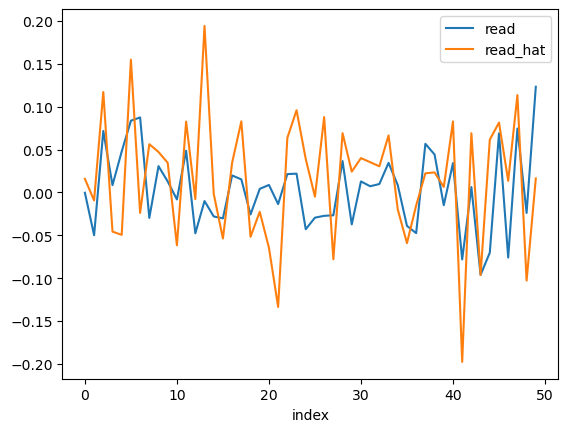

In [38]:
from random import randint
seq = dictionary_of_reference["NZ_CP010823.1"]
rand_idx = randint(0, len(seq) - 201)
read = seq[rand_idx:rand_idx+200]

read_enc = torch.Tensor(eval_model.encode([read])).to('cuda')
enc = vae.enc(read_enc)
#print(enc)
read_hat = vae(read_enc)
print("Loss:", F.mse_loss(read_enc, read_hat).item())
#print(read_enc)
#print(read_hat)

import matplotlib.pyplot as plt
plt.plot(read_enc.detach().cpu().numpy()[:50], label="read")
plt.plot(read_hat.detach().cpu().numpy()[:50], label="read_hat")
plt.xlabel("index")
plt.legend()